In [12]:
#=
K1 and K2 plotting
=#
using TCI4Keldysh
using PythonCall
using PythonPlot
using LaTeXStrings

INCH_TO_PT = 72
PT_TO_INCH = 1.0/INCH_TO_PT
COLUMN_PT = 432
COLUMN_INCH = COLUMN_PT*PT_TO_INCH
PLOT_COLUMN_PT = 420
PLOT_COLUMN_INCH = PLOT_COLUMN_PT*PT_TO_INCH
PLOT_PAGE_PT = PLOT_COLUMN_PT*2
PLOT_PAGE_INCH = PLOT_PAGE_PT*PT_TO_INCH

function set_rcParams(fs::Int=12)
    pyplot.rcParams["font.size"] = fs        # Title font size
    # pyplot.rcParams["axes.labelsize"] = fs               # Axis label font size
    pyplot.rcParams["xtick.labelsize"] = fs             # X-axis tick label font size
    pyplot.rcParams["ytick.labelsize"] = fs             # Y-axis tick label font size
    pyplot.rcParams["legend.fontsize"] = fs             # Legend font size
end
set_rcParams(12)

function annotate_topleft(ax, text; color="black", fontsize=14)
    subplotlabeloffset=3
    ax.annotate(
    text,
    xy=(0,1),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(+subplotlabeloffset, -subplotlabeloffset),
    textcoords="offset points",
    color=color,
    fontsize=fontsize
    )
end

function annotate_bottomleft(ax, text; color="black", fontsize=14)
    subplotlabeloffset=3
    ax.annotate(
    text,
    xy=(0,0),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="bottom",
    xytext=(+subplotlabeloffset, +subplotlabeloffset),
    textcoords="offset points",
    color=color,
    fontsize=fontsize
    )
end


function annotate_topright(ax, text; color="black", fontsize=14)
    subplotlabeloffset=3
    ax.annotate(
    text,
    xy=(1,1),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="top",
    xytext=(-subplotlabeloffset, -subplotlabeloffset),
    textcoords="offset points",
    color=color,
    fontsize=fontsize
    )
end

function annotate_bottomright(ax, text; color="black", fontsize=14)
    subplotlabeloffset=3
    ax.annotate(
    text,
    xy=(1,0),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="bottom",
    xytext=(-subplotlabeloffset, +subplotlabeloffset),
    textcoords="offset points",
    color=color,
    fontsize=fontsize
    )
end

"""
legend with one column, labels for colors and markers
"""
function onecol_legend_colormarker(colors, markers, collabels, markerlabels)
    @assert length(colors)>=length(collabels)
    @assert length(markers)>=length(markerlabels)

    mlines = pyimport("matplotlib.lines")
    collines = [mlines.Line2D([], [], color=colors[j], label=collabels[j]) for j in eachindex(collabels)]
    markerlines = [mlines.Line2D([], [], color="black", marker=markers[j], label=markerlabels[j], linestyle="None") for j in eachindex(markerlabels)]

    handles = vcat(collines, markerlines)
    return handles
end

"""
Save figure including a legend outside the figure (bbox_to_anchor with entries > 1.0)
"""
function save_bbox(name::String, fig, lgd)
    fig.savefig(
        name,
        bbox_extra_artists=(lgd,),
        bbox_inches="tight"
        )
end

function abc_annotate(axs; color="black", yoff=nothing, xoff=nothing)
    subplotlabeloffset=3
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    naxs = length(axs.flatten())
    for i in 0:naxs-1
        axs.flatten()[i].annotate(
        "($(alphabet[i+1]))",
        xy=(1,1),
        xycoords="axes fraction",
        horizontalalignment="right",
        verticalalignment="top",
        xytext=(-(isnothing(xoff) ? subplotlabeloffset : xoff), -(isnothing(yoff) ? subplotlabeloffset : yoff)),
        textcoords="offset points",
        color=color
        )
    end
end

function remove_ticks(ax)
    ax.tick_params(
        axis="both",
        which="both",
        labelbottom=false,
        labelleft=false,
        bottom=false,
        left=false
    )
end

function center_ticks(ax)
    ticks = ax.xaxis.get_majorticklabels()
    ticks[0].set_horizontalalignment("left")
    nticks = length(ticks)
    ticks[nticks-1].set_horizontalalignment("right")
end

center_ticks (generic function with 1 method)

In [15]:
PSFpath = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
flavor_idx = 1
# NOT p-channel because K1, K2 are zero there!
channel = "t"
prime = false

beta20path = joinpath(TCI4Keldysh.datadir(), "siam05_U0.05_T0.05_Delta0.0318/PSF_nz=2_conn_zavg")
beta200path = joinpath(TCI4Keldysh.datadir(), "siam05_U0.05_T0.005_Delta0.0318/PSF_nz=2_conn_zavg")
beta2000path = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")

u05path = joinpath(TCI4Keldysh.datadir(), "SIAM_u=0.50/PSF_nz=4_conn_zavg/")
u10path = joinpath(TCI4Keldysh.datadir(), "SIAM_u=1.00/PSF_nz=4_conn_zavg/")
u15path = joinpath(TCI4Keldysh.datadir(), "SIAM_u=1.50/PSF_nz=4_conn_zavg/")
u30path = joinpath(TCI4Keldysh.datadir(), "SIAM_u3_U0.05_T0.0005_Delta0.0053052/PSF_nz=2_conn_zavg")
u50path = joinpath(TCI4Keldysh.datadir(), "SIAM_u5_U0.05_T0.0005_Delta0.0031831/PSF_nz=2_conn_zavg")
upaths = [
u05path,
u10path,
u15path,
u30path,
u50path
]

true

Matsubara

In [18]:
import TensorCrossInterpolation as TCI
# collect Matsubara K2
R = 12

# tol vs rank
tol_vs_rank_K2 = Int[]
tols = 10.0 .^ (-5:-2)
for tol in tols
    T = TCI4Keldysh.dir_to_T(PSFpath)
    qtt = TCI4Keldysh.K2_TCI_precomputed(
        PSFpath, R;
        channel=channel, formalism="MF", flavor_idx=flavor_idx, T=T, tolerance=tol, unfoldingscheme=:interleaved, prime=prime
        )
    println("==== tol=$tol T=$T R=$R path=$PSFpath")
    push!(tol_vs_rank_K2, TCI.rank(qtt[1].tci))
end

# beta vs rank
betas = [20.0, 200.0, 2000.0]
betapaths = [beta20path, beta200path, beta2000path]
tol = 1.e-3
betaranks_K2 = Int[]
for i in eachindex(betas)
    beta = betas[i]
    path = betapaths[i]
    T = 1.0/beta
    qtt = TCI4Keldysh.K2_TCI_precomputed(
        path, R;
        channel=channel, formalism="MF", flavor_idx=flavor_idx, T=T, tolerance=tol, unfoldingscheme=:interleaved, prime=prime
        )
    push!(betaranks_K2, TCI.rank(qtt[1].tci))
end

# u vs rank
us = [0.5, 1.0, 1.5, 3.0, 5.0]
tol = 1.e-3
uranks_K2 = Int[]
for up in upaths
    T = TCI4Keldysh.dir_to_T(up) 
    qtt = TCI4Keldysh.K2_TCI_precomputed(
        up, R;
        channel=channel, formalism="MF", flavor_idx=flavor_idx, T=T, tolerance=tol, unfoldingscheme=:interleaved, prime=prime
        )
    push!(uranks_K2, TCI.rank(qtt[1].tci))
end

  Compute K2...
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
==== tol=1.0e-5 T=0.0005 R=12 path=/scratch/m/M.Frankenbach/tci4keldysh/data/SIAM_u=0.50/PSF_nz=4_conn_zavg/
  Compute K2...
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
==== tol=0.0001 T=0.0005 R=12 path=/scratch/m/M.Frankenbach/tci4keldysh/data/SIAM_u=0.50/PSF_nz=4_conn_zavg/
  Compute K2...
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
==== tol=0.001 T=0.0005 R=12 path=/scratch/m/M.Frankenbach/tci4keldysh/data/SIAM_u=0.50/PSF_nz=4_conn_zavg/
  Compute K2...
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
size of Σ_vec:(8192,)
size of Σ_slanted: (4097, 4096)
==== tol=0.010000000000000002 T=0.0005 R=12 path=/scratch/m/M.Frankenbach/tci4keldysh/data/SIAM_u=0.50/PSF_nz=4_conn_zavg/
  Compute K2...
size of Σ_vec:(8192,)
size of Σ_slanted

In [19]:
import TensorCrossInterpolation as TCI
# collect Matsubara K1
R = 12

# tol vs rank
tol_vs_rank_K1 = Int[]
tols = 10.0 .^ (-5:-2)
for tol in tols
    T = TCI4Keldysh.dir_to_T(PSFpath)
    qtt = TCI4Keldysh.K1_TCI(
        PSFpath, R;
        channel=channel, formalism="MF", flavor_idx=flavor_idx, T=T, tolerance=tol, unfoldingscheme=:interleaved,
        )
    push!(tol_vs_rank_K1, TCI.rank(qtt[1].tci))
end

# beta vs rank
betas = [20.0, 200.0, 2000.0]
betapaths = [beta20path, beta200path, beta2000path]
tol = 1.e-3
betaranks_K1 = Int[]
for i in eachindex(betas)
    beta = betas[i]
    path = betapaths[i]
    T = 1.0/beta
    qtt = TCI4Keldysh.K1_TCI(
        path, R;
        channel=channel, formalism="MF", flavor_idx=flavor_idx, T=T, tolerance=tol, unfoldingscheme=:interleaved,
        )
    push!(betaranks_K1, TCI.rank(qtt[1].tci))
end

# u vs rank
us = [0.5, 1.0, 1.5, 3.0, 5.0]
tol = 1.e-3
uranks_K1 = Int[]
for up in upaths
    T = TCI4Keldysh.dir_to_T(up) 
    qtt = TCI4Keldysh.K1_TCI(
        up, R;
        channel=channel, formalism="MF", flavor_idx=flavor_idx, T=T, tolerance=tol, unfoldingscheme=:interleaved,
        )
    push!(uranks_K1, TCI.rank(qtt[1].tci))
end

==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...
==== Computing ["Q12", "Q34", "K1t"]...


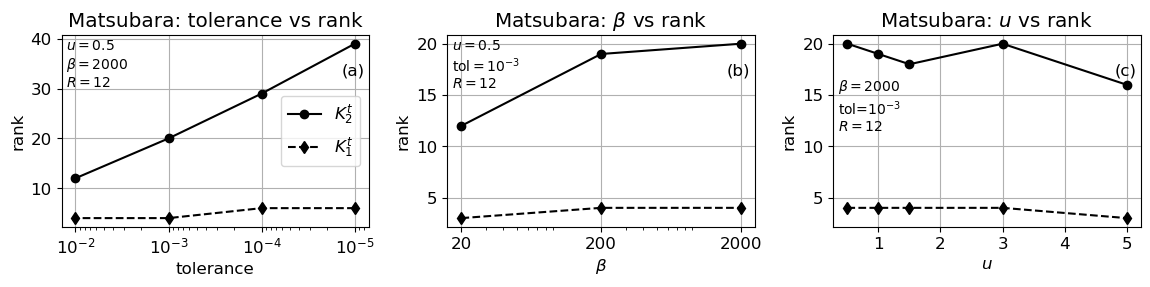

In [52]:
# plot
tols = 10.0 .^ (-5:-2)
fig, axs = subplots(1,3, figsize=(PLOT_PAGE_INCH, PLOT_PAGE_INCH*1.3/5))

for ax in axs
    ax.grid(true)
end

# tolerance
axs[0].plot(tols, tol_vs_rank_K2; color="black", marker="o", label=L"K_2^%$(channel)")
axs[0].plot(tols, tol_vs_rank_K1; color="black", marker="d", linestyle="dashed", label=L"K_1^%$(channel)")
axs[0].set_xscale("log")
axs[0].set_ylabel("rank")
axs[0].set_xlabel("tolerance")
axs[0].set_title("Matsubara: tolerance vs rank")
axs[0].invert_xaxis()
# axs[0].legend(loc="center left", bbox_to_anchor=(0.0,0.6))
axs[0].legend(loc="best")
annotate_topleft(axs[0], L"u=0.5" * "\n" * L"\beta=2000" * "\n" * L"R=%$R"; fontsize=10)

# beta
axs[1].plot(betas, betaranks_K2; color="black", marker="o", label=L"K_2^%$(channel)")
axs[1].plot(betas, betaranks_K1; color="black", marker="d", linestyle="dashed", label=L"K_1^%$(channel)")
axs[1].set_xscale("log")
axs[1].set_ylabel("rank")
axs[1].set_xlabel(L"\beta")
axs[1].set_xticks(betas)
axs[1].set_xticklabels(["$(Int(beta))" for beta in betas])
axs[1].set_title(L"Matsubara: $\beta$ vs rank")
annotate_topleft(axs[1], L"u=0.5" * "\n" * L"tol$=10^{-3}$" * "\n" * L"R=%$R"; fontsize=10)

# u
axs[2].plot(us, uranks_K2; color="black", marker="o", label=L"K_2^%$(channel)")
axs[2].plot(us, uranks_K1; color="black", marker="d", linestyle="dashed", label=L"K_1^%$(channel)")
axs[2].set_ylabel("rank")
axs[2].set_xlabel(L"u")
axs[2].set_title(L"Matsubara: $u$ vs rank")
axs[2].annotate(
    L"\beta=2000" * "\n" * L"tol=$10^{-3}$" * "\n" * L"R=%$R";
    xy=(0,0.8),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(+3, -3),
    textcoords="offset points",
    color="black",
    fontsize=10
) 

abc_annotate(axs; yoff=20)
tight_layout()
savefig("K12_ranks_MF.pdf")
display(fig)

Keldysh

In [35]:

import TensorCrossInterpolation as TCI
# collect Keldysh K2: estep=50, R=12: 38min
R = 12
ommax = 1.0
estep = 50
ik = (2,1,1)

function _to_basepath(psfpath)
    return Base.dirname(rstrip(psfpath, '/'))
end

# tol vs rank
tol_vs_rank_K2_KF = Int[]
tols = [2.e-3, 4.e-3, 6.e-3, 1.e-2]
for tol in tols
    @time begin qtt = TCI4Keldysh.K2_TCI_KF(
            PSFpath, R;
            channel=channel,
            flavor_idx=flavor_idx,
            ik=ik,
            tolerance=tol,
            unfoldingscheme=:interleaved,
            prime=prime,
            estep=estep,
            ommax=ommax
            )
    end
    push!(tol_vs_rank_K2_KF, TCI.rank(qtt.tci))
end

# beta vs rank
betas = [20.0, 200.0, 2000.0]
betapaths = [beta20path, beta200path, beta2000path]
tol = 1.e-2
betaranks_K2_KF = Int[]
for i in eachindex(betas)
    beta = betas[i]
    path = betapaths[i]
    qtt = TCI4Keldysh.K2_TCI_KF(
        path, R;
        channel=channel,
        flavor_idx=flavor_idx,
        tolerance=tol,
        unfoldingscheme=:interleaved,
        prime=prime,
        ik=ik,
        estep=estep,
        ommax=ommax
        )
    push!(betaranks_K2_KF, TCI.rank(qtt.tci))
end

# u vs rank
us = [0.5, 1.0, 1.5, 3.0, 5.0]
tol = 1.e-2
uranks_K2_KF = Int[]
for up in upaths
    qtt = TCI4Keldysh.K2_TCI_KF(
        up, R;
        channel=channel,
        flavor_idx=flavor_idx,
        ik=ik,
        tolerance=tol,
        unfoldingscheme=:interleaved,
        prime=prime,
        estep=estep,
        ommax=ommax
        )
    push!(uranks_K2_KF, TCI.rank(qtt.tci))
end

ωconvMat_Σ = [-1 0; 0 -1; -1 -1]
ωconvOff_Σ = [4097]
trafo_act = [0 -1]
(first(only(ωs_Σ)), last(only(ωs_Σ))) = (-0.999755859375, 0.999755859375)
(first.(ωs_ext), last.(ωs_ext)) = ((-1.0, -0.999755859375), (1.0, 0.999755859375))
Loading stuff:   0.014468 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  10.253646 seconds (13.13 M allocations: 22.745 GiB, 18.50% gc time)
All the rest:   1.665732 seconds (118.74 k allocations: 2.416 GiB, 21.17% gc time)
Loading stuff:   0.105031 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  10.112603 seconds (13.13 M allocations: 22.745 GiB, 15.59% gc time)
All the rest:   1.676441 seconds (119.30 k allocations: 2.427 GiB, 22.26% gc time)
Loading stuff:   0.034391 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:   9.896885 seconds (13.13 M allocations: 22.745 GiB, 12.94% gc time)
All the rest:   1.745661 seconds (119.30 k allocations: 2.427 GiB, 20.99% gc time)
ωconvMat_Σ = [-1 0; 0 -1; -1 -1]
ωconvOff_Σ =

In [36]:
import TensorCrossInterpolation as TCI
# collect Keldysh K1
R = 12
estep = 50
ommax = 1.0
ik = (2,2)

# tol vs rank
tol_vs_rank_K1_KF = Int[]
tols = [2.e-3, 4.e-3, 6.e-3, 1.e-2]
for tol in tols
    T = TCI4Keldysh.dir_to_T(PSFpath)
    qtt = TCI4Keldysh.K1_TCI(
        PSFpath, R;
        channel=channel,
        formalism="KF",
        flavor_idx=flavor_idx,
        T=T,
        tolerance=tol,
        unfoldingscheme=:interleaved,
        ωmax=ommax,
        estep=estep 
        )
    push!(tol_vs_rank_K1_KF, TCI.rank(qtt[ik...].tci))
end

# beta vs rank
betas = [20.0, 200.0, 2000.0]
betapaths = [beta20path, beta200path, beta2000path]
tol = 1.e-2
betaranks_K1_KF = Int[]
for i in eachindex(betas)
    beta = betas[i]
    path = betapaths[i]
    T = 1.0/beta
    qtt = TCI4Keldysh.K1_TCI(
        path, R;
        channel=channel,
        formalism="KF",
        flavor_idx=flavor_idx,
        T=T,
        tolerance=tol,
        unfoldingscheme=:fused,
        ωmax=ommax,
        estep=estep 
        )
    push!(betaranks_K1_KF, TCI.rank(qtt[ik...].tci))
end

# u vs rank
us = [0.5, 1.0, 1.5, 3.0, 5.0]
tol = 1.e-2
uranks_K1_KF = Int[]
for up in upaths
    T = TCI4Keldysh.dir_to_T(up) 
    qtt = TCI4Keldysh.K1_TCI(
        up, R;
        channel=channel,
        formalism="KF",
        flavor_idx=flavor_idx,
        T=T,
        tolerance=tol,
        unfoldingscheme=:fused,
        ωmax=ommax,
        estep=estep
        )
    push!(uranks_K1_KF, TCI.rank(qtt[ik...].tci))
end

Loading stuff:   0.008826 seconds (484 allocations: 22.898 KiB)
Creating Broadened PSFs:   0.121561 seconds (211.51 k allocations: 253.208 MiB, 19.95% gc time)
All the rest:   0.080184 seconds (2.48 k allocations: 190.235 MiB)
==== Computing ["Q12", "Q34", "K1t"]...
Loading stuff:   0.001504 seconds (484 allocations: 22.898 KiB)
Creating Broadened PSFs:   0.103420 seconds (211.51 k allocations: 253.208 MiB, 9.76% gc time)
All the rest:   0.079271 seconds (2.48 k allocations: 190.235 MiB)
==== Computing ["Q12", "Q34", "K1t"]...
Loading stuff:   0.001686 seconds (484 allocations: 22.898 KiB)
Creating Broadened PSFs:   0.122126 seconds (211.51 k allocations: 253.208 MiB, 6.46% gc time)
All the rest:   0.112435 seconds (2.48 k allocations: 190.235 MiB, 6.41% gc time)
==== Computing ["Q12", "Q34", "K1t"]...
Loading stuff:   0.001864 seconds (484 allocations: 22.898 KiB)
Creating Broadened PSFs:   0.093328 seconds (211.51 k allocations: 253.208 MiB)
All the rest:   0.125440 seconds (2.52 k a

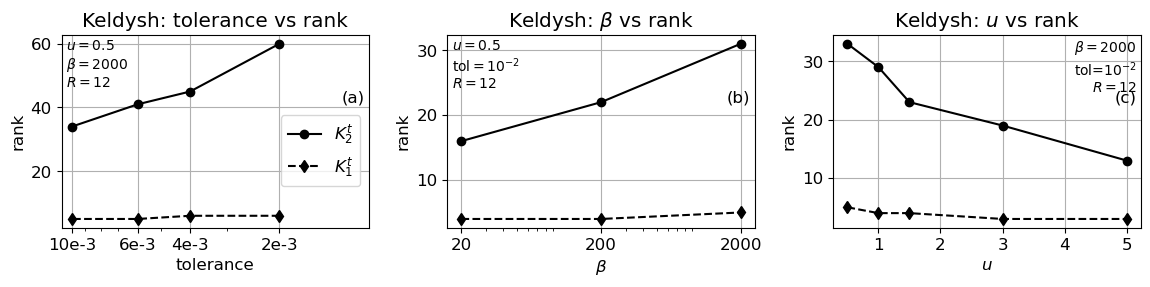

In [49]:
 
# plot
fig, axs = subplots(1,3, figsize=(PLOT_PAGE_INCH, PLOT_PAGE_INCH*1.3/5))

for ax in axs
    ax.grid(true)
end

# tolerance
axs[0].plot(tols, tol_vs_rank_K2_KF; color="black", marker="o", label=L"K_2^%$(channel)")
axs[0].plot(tols, tol_vs_rank_K1_KF; color="black", marker="d", linestyle="dashed", label=L"K_1^%$(channel)")
axs[0].set_xscale("log")
axs[0].set_ylabel("rank")
axs[0].set_xlabel("tolerance")
axs[0].set_title("Keldysh: tolerance vs rank")

axs[0].invert_xaxis()
axs[0].set_xticks([1.e-2,1.e-3])
axs[0].tick_params(labelbottom=false, bottom=false)
axs[0].set_xticks(tols)
ticklabels = ["$(Int(t/1.e-3))e-3" for t in tols]
axs[0].set_xticklabels(ticklabels)
axs[0].tick_params(labelbottom=true, bottom=true)
# axs[0].legend(loc="center left", bbox_to_anchor=(0.0,0.6))
annotate_topleft(axs[0], L"u=0.5" * "\n" * L"\beta=2000" * "\n" * L"R=%$R"; fontsize=10)

# beta
axs[1].plot(betas, betaranks_K2_KF; color="black", marker="o", label=L"K_2^%$(channel)")
axs[1].plot(betas, betaranks_K1_KF; color="black", marker="d", linestyle="dashed", label=L"K_1^%$(channel)")
axs[1].set_xscale("log")
axs[1].set_ylabel("rank")
axs[1].set_xlabel(L"\beta")
axs[1].set_xticks(betas)
axs[1].set_xticklabels(["$(Int(beta))" for beta in betas])
axs[1].set_title(L"Keldysh: $\beta$ vs rank")
annotate_topleft(axs[1], L"u=0.5" * "\n" * L"tol$=10^{-2}$" * "\n" * L"R=%$R"; fontsize=10)

# u
axs[2].plot(us, uranks_K2_KF; color="black", marker="o", label=L"K_2^%$(channel)")
axs[2].plot(us, uranks_K1_KF; color="black", marker="d", linestyle="dashed", label=L"K_1^%$(channel)")
axs[2].set_ylabel("rank")
axs[2].set_xlabel(L"u")
axs[2].set_title(L"Keldysh: $u$ vs rank")
annotate_topright(axs[2], L"\beta=2000" * "\n" * L"tol=$10^{-2}$" * "\n" * L"R=%$R"; fontsize=10)
axs[0].legend(loc="right", bbox_to_anchor=(1.0,0.4))

abc_annotate(axs; yoff=40)
tight_layout()
savefig("K12_ranks_KF.pdf")
display(fig)

In [10]:
# find highest rank K2 component
channel = "t"
flavor_idx = 1
tolerance = 1.e-2
T = TCI4Keldysh.dir_to_T(PSFpath)
R = 12
estep = 50
ommax = 1.0

@time begin
    qtt = TCI4Keldysh.K1_TCI(
        PSFpath, R;
        channel=channel,
        formalism="KF",
        flavor_idx=flavor_idx,
        T=T,
        tolerance=tolerance,
        unfoldingscheme=:fused,
        estep=estep,
        ωmax=ommax
        )
    ranks = zeros(Int, size(qtt))
    for i in eachindex(qtt)
        if !isnothing(qtt[i])
            ranks[i] = TCI.rank(qtt[i].tci)
        end
    end
    println("K1 ranks for different components")
    display(ranks)
end

@time begin
    qtt = TCI4Keldysh.K2_TCI_precomputed(
        PSFpath, R;
        channel=channel,
        formalism="KF",
        flavor_idx=flavor_idx,
        T=T,
        tolerance=tolerance,
        unfoldingscheme=:fused,
        prime=prime,
        estep=estep,
        ωmax=ommax
        )
    ranks = zeros(Int, size(qtt))
    for i in eachindex(qtt)
        if !isnothing(qtt[i])
            ranks[i] = TCI.rank(qtt[i].tci)
        end
    end
    display(ranks)
end

Loading stuff:   0.001484 seconds (484 allocations: 22.898 KiB)
Creating Broadened PSFs:   0.161302 seconds (211.51 k allocations: 253.208 MiB, 39.62% gc time)
All the rest:   0.211505 seconds (2.48 k allocations: 190.235 MiB, 23.61% gc time)
==== Computing ["Q12", "Q34", "K1t"]...
K1 ranks for different components
  2.636084 seconds (5.17 M allocations: 779.085 MiB, 19.79% gc time, 68.92% compilation time)
Loading stuff:   0.001508 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  10.669050 seconds (13.13 M allocations: 22.744 GiB, 22.46% gc time)
All the rest:   3.014629 seconds (118.75 k allocations: 4.487 GiB, 23.66% gc time)
Loading stuff:   0.001497 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:   9.117145 seconds (13.13 M allocations: 22.745 GiB, 13.69% gc time)
All the rest:   3.125564 seconds (119.31 k allocations: 4.507 GiB, 25.92% gc time)
Loading stuff:   0.002191 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  16.369756 seco

2×2 Matrix{Int64}:
 0  4
 4  5

2×2×2 Array{Int64, 3}:
[:, :, 1] =
 29  24
 32  26

[:, :, 2] =
 24   0
 25  22

In [22]:
import TensorCrossInterpolation as TCI
# find R saturation of K2
channel = "t"
flavor_idx = 1
tolerance = 1.e-2
estep = 50
ommax = 1.0
ik = (2,1,1)
ranks = []

for R in 10:2:14
    @time begin
        println("\n---------- R=$R")
        qtt = TCI4Keldysh.K2_TCI_KF(
            PSFpath,
            R;
            channel=channel,
            flavor_idx=flavor_idx,
            prime=prime,
            estep=estep,
            ommax=ommax,
            ik=ik,
            unfoldingscheme=:fused,
            tolerance=tolerance
            )
        rank = TCI.rank(qtt.tci)
        push!(ranks, rank)
    end
end
@show ranks


---------- R=10
ωconvMat_Σ = [-1 0; 0 -1; -1 -1]
ωconvOff_Σ = [1025]
trafo_act = [0 -1]
(first(only(ωs_Σ)), last(only(ωs_Σ))) = (-0.9990234375, 0.9990234375)
(first.(ωs_ext), last.(ωs_ext)) = ((-1.0, -0.9990234375), (1.0, 0.9990234375))
Loading stuff:   0.001215 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  10.641043 seconds (13.13 M allocations: 22.744 GiB, 24.03% gc time)
All the rest:   0.489960 seconds (118.73 k allocations: 883.182 MiB, 9.16% gc time)
Loading stuff:   0.001374 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:   9.658905 seconds (13.13 M allocations: 22.745 GiB, 19.21% gc time)
All the rest:   0.447836 seconds (119.29 k allocations: 887.151 MiB, 0.76% gc time)
Loading stuff:   0.001828 seconds (454 allocations: 201.406 KiB)
Creating Broadened PSFs:  10.093389 seconds (13.13 M allocations: 22.745 GiB, 18.61% gc time)
All the rest:   0.450526 seconds (119.29 k allocations: 887.151 MiB, 1.26% gc time)
ωconvMat_Σ = [-1 0; 0 -1; -1 -1]


3-element Vector{Any}:
 28
 31
 31